In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t

path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/10 Chilled 120BPM
  01 8th Cym.mid
  02 8th Hat.mid
  03 8th Cym.mid
  04 8th Hat.mid
  05 16th Hat.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/11 Disco Dancer 135BPM
  01 4th Hat .mid
  02 8th Hat.mid
  03 8th Hat.mid
  04 16th Hat.mid
  05 8th Cym.mid
  06 4th Cym.mid
  07 4th Perc.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/12 Sticks Up 155BPM
  01 8th Perc.mid
  02 8th Hat.mid
  03 16th Hat.mid
  04 8th Cym.mid
  05 8th Perc.mid
  06 8th Perc.mid
  07 8th Cym.mid

Encoding midi-data
 500
> -> multi-track = True none
 [INFO] : 
 |  True


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [9]:
dn = config.dataset_dir + 'drum_midi/' + '50´s Drummer MIDI Files'
# for a in os.walk(config.dataset_dir + 'drum_midi'):
#     print(a)
sorted(os.listdir(dn))

['.DS_Store',
 "01 Rock'n'Roll",
 '02 Blues',
 '03 Traditional Pop',
 '04 Country',
 '05 Jazz',
 '06 Soul - Funk',
 '07 Indie']

In [10]:
unique_genres = set(genre[-2] +'/'+ genre[-1] for genre in genres)
len(unique_genres)

72

In [11]:
unique_genres

{"01 Rock'n'Roll/01 Dancin Rick 166BPM",
 "01 Rock'n'Roll/02 Gogo 191BPM",
 "01 Rock'n'Roll/03 Lips n Hips 152BPM",
 "01 Rock'n'Roll/04 Maybelline 233BPM",
 "01 Rock'n'Roll/05 Straight Line 136BPM",
 "01 Rock'n'Roll/06 Moonglow 140BPM",
 "01 Rock'n'Roll/07 Thwag 170BPM",
 "01 Rock'n'Roll/08 Doowoop 140bpm",
 "01 Rock'n'Roll/09 Diddeley 185bpm",
 "01 Rock'n'Roll/10 Ottis 172bpm",
 '02 Blues/01 Booze 92BPM',
 '02 Blues/02 Nappy Brown 160BPM',
 '02 Blues/03 Noton Bull 192BPM 12-8 Brushes',
 '02 Blues/04 Mickeys 212BPM 12-8',
 '02 Blues/05 Cadillac 128BPM',
 '02 Blues/06 Vidar Vega 70BPM',
 '02 Blues/07 Straight 88BPM',
 '02 Blues/08 Sams 127BPM',
 '02 Blues/09 Leroyes 130BPM',
 '02 Blues/10 Bogeart 122BPM',
 '03 Traditional Pop/01 Fly High 115BPM',
 '03 Traditional Pop/02 Frankies Girl 116BPM',
 '03 Traditional Pop/03 King Quiza 102BPM',
 '03 Traditional Pop/04 Love 155BPM',
 '03 Traditional Pop/05 Your Eyes 80BPM',
 '03 Traditional Pop/06 Bopop 130MPM',
 '03 Traditional Pop/07 Lester Lee

In [12]:
x_train.shape

(500, 160, 10, 1)

In [13]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 160, 10, 1), 450)

In [14]:
x_test = x_train[m:]
x_train = x_train[:m]

In [15]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres[:m])

In [16]:
# i = 0
# j = 399
# plot.single(x_train[i, :50,:,0])
# plot.single(x_train[j, :50,:,0])
# # plot.single(x_train[2a, :50,:,0])
# np.array(labels)[[i,j]]

In [17]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [18]:
latent_dim = 10
epsilon_std = 1.0

In [19]:
vae, encoder, generator = models.build(input_shape, latent_dim)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


In [20]:
batch_size = 128
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [21]:
# phase_mod = 0.01
# whitening = False

In [22]:
# m = 1000
# useDataGenerator = False
# # useDataGenerator = True
# callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

# x = x_train[:m]
# # x = x_train
# # i = [0,1, 7,8, 14,15, 399,400]
# # x = x_train[i]
# # x = np.concatenate([x for _ in range(10)])
# print('x:', x.shape)

# print('batch_size: %i' % batch_size)
# print('update-iterations:', round(epochs * x.shape[0] / batch_size))
# if useDataGenerator:
#     datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
#     history = collections.defaultdict(list)
#     n_batches = datagen.__len__()
#     for e in range(epochs):
#         print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
#         for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
#             print(' Batch %i/%i' % (batch_i,n_batches))
#             x_ = x_batch
#             # x_ = datagen.shuffle_3rd_dim(x_)
#             # x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
#             h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
#             for k,v in h.history.items(): 
#                 print(' \\_%s' % k, [round(v_,) for v_ in v])
#                 history[k].append(v)
#             if batch_i >= n_batches:
#                 break
# else:
#     h = vae.fit(x, epochs=epochs, validation_data=(x_test, None), callbacks=callbacks)
#     history = h.history

In [23]:
name = 'non-functional_model.h5'
fn = config.model_dir + name

In [24]:
# io.save_dict('../logs/','train_loss', history)

In [25]:
# # for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
# #     model.save_weights(dn + prefix + suffix + '.h5', "w")
# vae.save_weights(fn, "w")

In [26]:
vae.load_weights(fn)

In [27]:
# vae.save(fn + '__save')

In [28]:
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.ylim(0,150)

m (50, 10, 1)


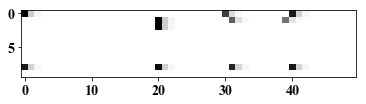

m (50, 10, 1)


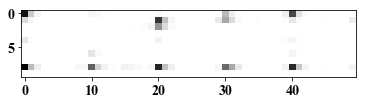

m (50, 10, 1)


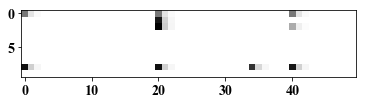

m (50, 10, 1)


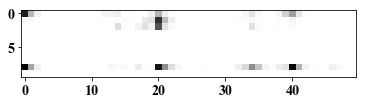

In [29]:
i,j = 240, 30
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

m (50, 10, 1)


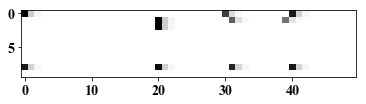

m (50, 10, 1)


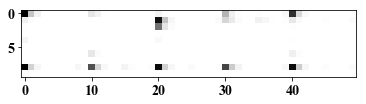

m (50, 10, 1)


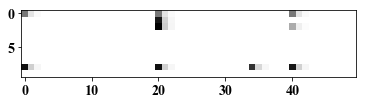

m (50, 10, 1)


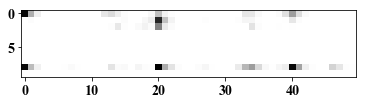

In [30]:
i,j = 0, 10
i,j = 240, 30

m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [31]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [32]:
# # min: these pixels are 'always' active
# m = x.min(axis=0)
# plot.multi(m[:30,:,0])

In [33]:
# # mean
# m = x.mean(axis=0)
# plot.single(m[:30,:,0])

## Encoder + Decoder (generator)
A model to project inputs on the latent space

In [34]:
# # build a model to project inputs on the latent space
# encoder = Model(encoder_input, z_mean)

In [35]:
# generator_input = Input((latent_dim,))
# generator_layers_ = utils.composition(decoders, generator_input)
# generator = Model(generator_input, generator_layers_)

In [36]:
decoder = generator

## Style transfer

In [37]:
import sklearn.feature_selection
import sklearn.ensemble

In [38]:
# pca = PCA(n_components=3)
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009,
# depending on the shape of the input data and the number of components to extract.

In [39]:
m = 1000
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(450, 10)

In [40]:
# a = list({3:[2],'s':[3,3]}.keys())
# np.random.shuffle(a)
# a

In [41]:
import transformation_extraction

In [42]:
d = {'a':3, 'b':2}
dd = np.array(list(d.keys()))

In [43]:
best_dims, importances, transformations, min_transformations = \
    transformation_extraction.between_genres(x_train_encoded, genre_dict, amt1=1000, amt2=1, v=1)


0
Genre A: 02 Blues/02 Nappy Brown 160BPM
  genre B: 	04 Country/07 Trainy 100BPM (len: 7)
 	 i: 1, importance: 0.305825

1
Genre A: 03 Traditional Pop/04 Love 155BPM

2
Genre A: 04 Country/07 Trainy 100BPM
  genre B: 	03 Traditional Pop/02 Frankies Girl 116BPM (len: 7)
 	 i: 6, importance: 0.284557

3
Genre A: 06 Soul - Funk/02 Boogaloo 120BPM
  genre B: 	05 Jazz/01 Amel 85BPM Brushes (len: 7)
 	 i: 1, importance: 0.260432

4
Genre A: 06 Soul - Funk/04 GoGo Soul 100BPM
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 0, importance: 0.280681

5
Genre A: 07 Indie/01 Rock Shuffle 130BPM
  genre B: 	02 Blues/09 Leroyes 130BPM (len: 7)
 	 i: 7, importance: 0.325163

6
Genre A: 01 Rock'n'Roll/02 Gogo 191BPM
  genre B: 	06 Soul - Funk/05 Hip Hop 95BPM (len: 7)
 	 i: 0, importance: 0.292460

7
Genre A: 02 Blues/09 Leroyes 130BPM
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 7, importance: 0.225265

8
Genre A: 01 Rock'n'Roll/05 Straight Line 136BPM
  genre B: 	06 Soul - Funk/

  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 8, importance: 0.291737

67
Genre A: 04 Country/05 Brewer 160BPM
  genre B: 	03 Traditional Pop/03 King Quiza 102BPM (len: 7)
 	 i: 6, importance: 0.172090

68
Genre A: 01 Rock'n'Roll/01 Dancin Rick 166BPM
  genre B: 	04 Country/08 Eddie Ed 111BPM (len: 7)
 	 i: 6, importance: 0.232374

69
Genre A: 01 Rock'n'Roll/04 Maybelline 233BPM
  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 0, importance: 0.356567

70
Genre A: 01 Rock'n'Roll/06 Moonglow 140BPM
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 1, importance: 0.257601

71
Genre A: 02 Blues/10 Bogeart 122BPM
  genre B: 	04 Country/02 Marching 94BPM (len: 7)
 	 i: 0, importance: 0.166964

72
Genre A: 05 Jazz/10 Scalis 190BPM 3-4
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 0, importance: 0.283591

73
Genre A: 05 Jazz/01 Amel 85BPM Brushes
  genre B: 	02 Blues/02 Nappy Brown 160BPM (len: 7)
 	 i: 6, importance: 0.370232

74
Genre A: 04 Countr

  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 2, importance: 0.225359

130
Genre A: 04 Country/10 Rough Rider 183BPM
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 7, importance: 0.244507

131
Genre A: 01 Rock'n'Roll/01 Dancin Rick 166BPM
  genre B: 	06 Soul - Funk/05 Hip Hop 95BPM (len: 7)
 	 i: 0, importance: 0.338835

132
Genre A: 03 Traditional Pop/04 Love 155BPM
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 8, importance: 0.218660

133
Genre A: 01 Rock'n'Roll/02 Gogo 191BPM
  genre B: 	07 Indie/01 Rock Shuffle 130BPM (len: 7)
 	 i: 9, importance: 0.174187

134
Genre A: 07 Indie/04 Titanic 97BPM
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 6, importance: 0.218971

135
Genre A: 01 Rock'n'Roll/01 Dancin Rick 166BPM
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.341998

136
Genre A: 01 Rock'n'Roll/05 Straight Line 136BPM
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance

  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 9, importance: 0.276700

194
Genre A: 03 Traditional Pop/05 Your Eyes 80BPM
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 1, importance: 0.218499

195
Genre A: 07 Indie/03 Moon 137BPM
  genre B: 	02 Blues/03 Noton Bull 192BPM 12-8 Brushes (len: 7)
 	 i: 9, importance: 0.216028

196
Genre A: 06 Soul - Funk/08 Rim Soul 90BPM
  genre B: 	05 Jazz/05 TNT 116BPM (len: 7)
 	 i: 0, importance: 0.393212

197
Genre A: 04 Country/04 Snarey 208BPM 3-4
  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 6, importance: 0.280793

198
Genre A: 06 Soul - Funk/09 Smooth Soul 81BPM
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 0, importance: 0.228226

199
Genre A: 03 Traditional Pop/04 Love 155BPM
  genre B: 	04 Country/02 Marching 94BPM (len: 7)
 	 i: 8, importance: 0.252196

200
Genre A: 06 Soul - Funk/02 Boogaloo 120BPM
  genre B: 	03 Traditional Pop/08 Cecil Cee 101BPM (len: 7)
 	 i: 9, importance: 0.154700

201
G

  genre B: 	03 Traditional Pop/05 Your Eyes 80BPM (len: 7)
 	 i: 6, importance: 0.156660

257
Genre A: 03 Traditional Pop/04 Love 155BPM
  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 8, importance: 0.291901

258
Genre A: 02 Blues/06 Vidar Vega 70BPM
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.198787

259
Genre A: 01 Rock'n'Roll/10 Ottis 172bpm
  genre B: 	06 Soul - Funk/10 Syncopated Ride 128BPM (len: 7)
 	 i: 3, importance: 0.173432

260
Genre A: 06 Soul - Funk/05 Hip Hop 95BPM
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 0, importance: 0.332208

261
Genre A: 02 Blues/08 Sams 127BPM
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 9, importance: 0.255940

262
Genre A: 05 Jazz/06 Nucleus 172BPM Brushes
  genre B: 	04 Country/10 Rough Rider 183BPM (len: 7)
 	 i: 5, importance: 0.271452

263
Genre A: 05 Jazz/06 Nucleus 172BPM Brushes
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.3

  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 5, importance: 0.288732

320
Genre A: 05 Jazz/02 Another You 170BPM
  genre B: 	04 Country/10 Rough Rider 183BPM (len: 7)
 	 i: 5, importance: 0.256801

321
Genre A: 05 Jazz/09 West Coast 152BPM Brushes
  genre B: 	06 Soul - Funk/05 Hip Hop 95BPM (len: 7)
 	 i: 0, importance: 0.338749

322
Genre A: 03 Traditional Pop/05 Your Eyes 80BPM
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 6, importance: 0.216261

323
Genre A: 04 Country/04 Snarey 208BPM 3-4
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 7, importance: 0.233107

324
Genre A: 06 Soul - Funk/03 Cadence Soul 105BPM
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 0, importance: 0.338455

325
Genre A: 04 Country/03 Straight 72BPM Brushes
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 0, importance: 0.302149

326
Genre A: 02 Blues/07 Straight 88BPM
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 9, importance: 0.227260

327

  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 6, importance: 0.275773

384
Genre A: 02 Blues/05 Cadillac 128BPM
  genre B: 	06 Soul - Funk/08 Rim Soul 90BPM (len: 7)
 	 i: 0, importance: 0.265872

385
Genre A: 06 Soul - Funk/05 Hip Hop 95BPM
  genre B: 	02 Blues/10 Bogeart 122BPM (len: 7)
 	 i: 0, importance: 0.393415

386
Genre A: 04 Country/02 Marching 94BPM
  genre B: 	06 Soul - Funk/03 Cadence Soul 105BPM (len: 7)
 	 i: 0, importance: 0.230520

387
Genre A: 05 Jazz/02 Another You 170BPM
  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 0, importance: 0.244393

388
Genre A: 03 Traditional Pop/10 Frewild 152BPM
  genre B: 	07 Indie/02 Rock Tribal 125BPM (len: 7)
 	 i: 9, importance: 0.367192

389
Genre A: 04 Country/09 Broonze 122BPM
  genre B: 	05 Jazz/03 Cool 137BPM Brushes (len: 7)
 	 i: 6, importance: 0.212467

390
Genre A: 05 Jazz/04 Silent Tear 234BPM
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 0, importance: 0.273951

391
Genre A: 06 Sou

  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.366953

447
Genre A: 03 Traditional Pop/01 Fly High 115BPM
  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 9, importance: 0.202651

448
Genre A: 05 Jazz/08 Neodop 226BPM 3-4
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 9, importance: 0.280816

449
Genre A: 02 Blues/10 Bogeart 122BPM
  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 6, importance: 0.221627

450
Genre A: 06 Soul - Funk/05 Hip Hop 95BPM
  genre B: 	02 Blues/05 Cadillac 128BPM (len: 7)
 	 i: 0, importance: 0.313249

451
Genre A: 07 Indie/01 Rock Shuffle 130BPM
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 7, importance: 0.255172

452
Genre A: 01 Rock'n'Roll/09 Diddeley 185bpm
  genre B: 	03 Traditional Pop/05 Your Eyes 80BPM (len: 7)
 	 i: 1, importance: 0.255005

453
Genre A: 07 Indie/03 Moon 137BPM
  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 9, importance: 0.321835

454
Genre 

  genre B: 	04 Country/07 Trainy 100BPM (len: 7)
 	 i: 2, importance: 0.215386

512
Genre A: 06 Soul - Funk/07 Ride Swing 95Bpm
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 9, importance: 0.283375

513
Genre A: 05 Jazz/06 Nucleus 172BPM Brushes
  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 0, importance: 0.365054

514
Genre A: 02 Blues/09 Leroyes 130BPM
  genre B: 	05 Jazz/05 TNT 116BPM (len: 7)
 	 i: 6, importance: 0.184610

515
Genre A: 01 Rock'n'Roll/10 Ottis 172bpm
  genre B: 	04 Country/07 Trainy 100BPM (len: 7)
 	 i: 4, importance: 0.173665

516
Genre A: 03 Traditional Pop/07 Lester Lee 133BPM
  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 0, importance: 0.388696

517
Genre A: 04 Country/04 Snarey 208BPM 3-4
  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.335964

518
Genre A: 01 Rock'n'Roll/03 Lips n Hips 152BPM
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.322109

519

  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 0, importance: 0.280316

576
Genre A: 01 Rock'n'Roll/02 Gogo 191BPM
  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 6, importance: 0.304311

577
Genre A: 02 Blues/06 Vidar Vega 70BPM
  genre B: 	02 Blues/09 Leroyes 130BPM (len: 7)
 	 i: 9, importance: 0.280656

578
Genre A: 02 Blues/04 Mickeys 212BPM 12-8
  genre B: 	02 Blues/09 Leroyes 130BPM (len: 7)
 	 i: 2, importance: 0.243564

579
Genre A: 05 Jazz/05 TNT 116BPM
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 4, importance: 0.160776

580
Genre A: 05 Jazz/10 Scalis 190BPM 3-4
  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 0, importance: 0.334288

581
Genre A: 04 Country/01 Calvin 148BPM
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 0, importance: 0.379866

582
Genre A: 02 Blues/10 Bogeart 122BPM
  genre B: 	04 Country/10 Rough Rider 183BPM (len: 7)
 	 i: 7, importance: 0.240066

583
Genre A: 04 Country/10 Rough Rider 183BPM
  genre B: 	0

  genre B: 	03 Traditional Pop/09 Distel 155BPM (len: 7)
 	 i: 0, importance: 0.301644

642
Genre A: 07 Indie/03 Moon 137BPM
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 7, importance: 0.137976

643
Genre A: 06 Soul - Funk/02 Boogaloo 120BPM
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 3, importance: 0.303928

644
Genre A: 04 Country/09 Broonze 122BPM
  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 6, importance: 0.224665

645
Genre A: 05 Jazz/07 Kooper 234BPM
  genre B: 	03 Traditional Pop/08 Cecil Cee 101BPM (len: 7)
 	 i: 9, importance: 0.302499

646
Genre A: 03 Traditional Pop/10 Frewild 152BPM
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 9, importance: 0.228928

647
Genre A: 04 Country/10 Rough Rider 183BPM
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 5, importance: 0.319085

648
Genre A: 07 Indie/01 Rock Shuffle 130BPM
  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 9, importance: 0.224644

649
Genre A: 04 Co

  genre B: 	02 Blues/07 Straight 88BPM (len: 7)
 	 i: 0, importance: 0.377430

706
Genre A: 05 Jazz/03 Cool 137BPM Brushes
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 0, importance: 0.191331

707
Genre A: 06 Soul - Funk/04 GoGo Soul 100BPM
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 7, importance: 0.269891

708
Genre A: 01 Rock'n'Roll/04 Maybelline 233BPM
  genre B: 	03 Traditional Pop/05 Your Eyes 80BPM (len: 7)
 	 i: 9, importance: 0.295041

709
Genre A: 04 Country/07 Trainy 100BPM
  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 0, importance: 0.336417

710
Genre A: 01 Rock'n'Roll/04 Maybelline 233BPM
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 4, importance: 0.332840

711
Genre A: 02 Blues/02 Nappy Brown 160BPM
  genre B: 	03 Traditional Pop/01 Fly High 115BPM (len: 7)
 	 i: 6, importance: 0.317880

712
Genre A: 05 Jazz/06 Nucleus 172BPM Brushes
  genre B: 	01 Rock'n'Roll/01 Dancin Rick 166BPM (len: 7)
 	 i: 0, importance: 0.347065



  genre B: 	04 Country/10 Rough Rider 183BPM (len: 7)
 	 i: 5, importance: 0.261902

769
Genre A: 04 Country/08 Eddie Ed 111BPM
  genre B: 	07 Indie/01 Rock Shuffle 130BPM (len: 7)
 	 i: 0, importance: 0.174254

770
Genre A: 07 Indie/01 Rock Shuffle 130BPM
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 4, importance: 0.236892

771
Genre A: 03 Traditional Pop/08 Cecil Cee 101BPM
  genre B: 	05 Jazz/03 Cool 137BPM Brushes (len: 7)
 	 i: 9, importance: 0.276537

772
Genre A: 03 Traditional Pop/02 Frankies Girl 116BPM
  genre B: 	04 Country/10 Rough Rider 183BPM (len: 7)
 	 i: 5, importance: 0.332324

773
Genre A: 02 Blues/06 Vidar Vega 70BPM
  genre B: 	05 Jazz/03 Cool 137BPM Brushes (len: 7)
 	 i: 9, importance: 0.293103

774
Genre A: 06 Soul - Funk/09 Smooth Soul 81BPM
  genre B: 	03 Traditional Pop/06 Bopop 130MPM (len: 7)
 	 i: 0, importance: 0.319608

775
Genre A: 04 Country/07 Trainy 100BPM
  genre B: 	02 Blues/05 Cadillac 128BPM (len: 7)
 	 i: 1, importance: 0.32242

  genre B: 	07 Indie/05 Halftime 71BPM (len: 2)
 	 i: 2, importance: 0.206812

833
Genre A: 01 Rock'n'Roll/05 Straight Line 136BPM
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 5, importance: 0.292536

834
Genre A: 01 Rock'n'Roll/03 Lips n Hips 152BPM
  genre B: 	05 Jazz/02 Another You 170BPM (len: 7)
 	 i: 0, importance: 0.280074

835
Genre A: 01 Rock'n'Roll/08 Doowoop 140bpm
  genre B: 	02 Blues/02 Nappy Brown 160BPM (len: 7)
 	 i: 6, importance: 0.329801

836
Genre A: 07 Indie/04 Titanic 97BPM
  genre B: 	07 Indie/01 Rock Shuffle 130BPM (len: 7)
 	 i: 5, importance: 0.143691

837
Genre A: 04 Country/04 Snarey 208BPM 3-4
  genre B: 	03 Traditional Pop/03 King Quiza 102BPM (len: 7)
 	 i: 0, importance: 0.254473

838
Genre A: 04 Country/02 Marching 94BPM
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 9, importance: 0.405360

839
Genre A: 04 Country/09 Broonze 122BPM

840
Genre A: 07 Indie/01 Rock Shuffle 130BPM
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (l

  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 0, importance: 0.357847

898
Genre A: 04 Country/04 Snarey 208BPM 3-4
  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 6, importance: 0.161465

899
Genre A: 06 Soul - Funk/08 Rim Soul 90BPM
  genre B: 	03 Traditional Pop/10 Frewild 152BPM (len: 7)
 	 i: 0, importance: 0.367334

900
Genre A: 02 Blues/02 Nappy Brown 160BPM
  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 6, importance: 0.283937

901
Genre A: 05 Jazz/04 Silent Tear 234BPM
  genre B: 	02 Blues/10 Bogeart 122BPM (len: 7)
 	 i: 5, importance: 0.238861

902
Genre A: 05 Jazz/08 Neodop 226BPM 3-4
  genre B: 	07 Indie/02 Rock Tribal 125BPM (len: 7)
 	 i: 9, importance: 0.230359

903
Genre A: 02 Blues/06 Vidar Vega 70BPM
  genre B: 	07 Indie/02 Rock Tribal 125BPM (len: 7)
 	 i: 9, importance: 0.420571

904
Genre A: 06 Soul - Funk/02 Boogaloo 120BPM
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 5, importance: 0.231297

905
Genre A

  genre B: 	06 Soul - Funk/08 Rim Soul 90BPM (len: 7)
 	 i: 0, importance: 0.292774

961
Genre A: 01 Rock'n'Roll/03 Lips n Hips 152BPM
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 5, importance: 0.212153

962
Genre A: 06 Soul - Funk/10 Syncopated Ride 128BPM

963
Genre A: 01 Rock'n'Roll/07 Thwag 170BPM
  genre B: 	03 Traditional Pop/07 Lester Lee 133BPM (len: 7)
 	 i: 6, importance: 0.267371

964
Genre A: 04 Country/03 Straight 72BPM Brushes
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 0, importance: 0.306449

965
Genre A: 03 Traditional Pop/02 Frankies Girl 116BPM
  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 9, importance: 0.323300

966
Genre A: 02 Blues/10 Bogeart 122BPM
  genre B: 	03 Traditional Pop/03 King Quiza 102BPM (len: 7)
 	 i: 9, importance: 0.181103

967
Genre A: 02 Blues/07 Straight 88BPM
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 6, importance: 0.333879

968
Genre A: 01 Rock'n'Roll/03 Lips n Hips 152BPM
  genre

In [44]:
print('avg importance: %f' % np.mean(importances))

avg importance: 0.263861


In [45]:
# list(min_transformations.items())[0]

In [46]:
for genre_A, d in min_transformations.items():
    print('\nGenre `%s` to: \n dim:\tgenre:' % genre_A)
    for genre_B, vector in d.items():
        print(' %i \t%s' % (np.argmax(vector), genre_B))  


Genre `02 Blues/02 Nappy Brown 160BPM` to: 
 dim:	genre:
 0 	07 Indie/05 Halftime 71BPM

Genre `03 Traditional Pop/04 Love 155BPM` to: 
 dim:	genre:
 4 	01 Rock'n'Roll/05 Straight Line 136BPM

Genre `04 Country/07 Trainy 100BPM` to: 
 dim:	genre:
 0 	02 Blues/04 Mickeys 212BPM 12-8

Genre `06 Soul - Funk/02 Boogaloo 120BPM` to: 
 dim:	genre:
 0 	05 Jazz/02 Another You 170BPM

Genre `06 Soul - Funk/04 GoGo Soul 100BPM` to: 
 dim:	genre:
 0 	05 Jazz/05 TNT 116BPM

Genre `07 Indie/01 Rock Shuffle 130BPM` to: 
 dim:	genre:
 1 	06 Soul - Funk/08 Rim Soul 90BPM

Genre `01 Rock'n'Roll/02 Gogo 191BPM` to: 
 dim:	genre:
 0 	06 Soul - Funk/07 Ride Swing 95Bpm

Genre `02 Blues/09 Leroyes 130BPM` to: 
 dim:	genre:
 9 	06 Soul - Funk/06 JB Groove 115BPM

Genre `01 Rock'n'Roll/05 Straight Line 136BPM` to: 
 dim:	genre:
 0 	01 Rock'n'Roll/03 Lips n Hips 152BPM

Genre `05 Jazz/05 TNT 116BPM` to: 
 dim:	genre:
 0 	03 Traditional Pop/04 Love 155BPM

Genre `03 Traditional Pop/05 Your Eyes 80BPM` to: 
 d

(array([317.,  80.,  69.,  21.,  51.,  67., 102.,  46.,  46., 188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

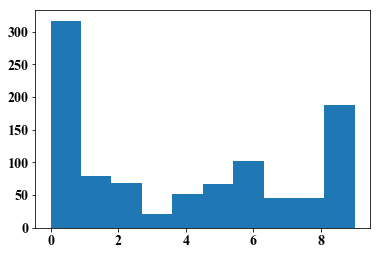

In [47]:
plt.hist(best_dims)

In [48]:
# TODO save as python object (or json)

In [49]:
# def save_transformation_dicts(transformations={}, dn='', v=0):
#     for genre_A, sub_dict in transformations.items():
#         # sub_dict :: {'genre_B_2/genre_B_2': vector}
#         a1, a2 = genre_A.split('/')
#         if a1 not in os.listdir(dn): os.mkdir(dn + a1)
#         if v:
#             print(genre_A)
#             print(sub_dict.keys())
#         io.save_dict(dn + a1, a2, sub_dict)

fn = config.plots_dir + 'transformations-best_dims.pkl'
io.save(best_dims, fn)

fn = config.plots_dir + 'transformations.pkl'
io.save(transformations, fn)

fn = config.plots_dir + 'min_transformations.pkl'
io.save(min_transformations, fn)

'../results/min_transformations.pkl'

In [50]:
t_ = io.load(fn)

In [51]:
# transformations = io.read_categorical_dict_dir(config.plots_dir + 'transformations/')
# min_transformations = io.read_categorical_dict_dir(config.plots_dir + 'min_transformations/') 

In [52]:
list(transformations.keys())[:3]

['02 Blues/02 Nappy Brown 160BPM',
 '03 Traditional Pop/04 Love 155BPM',
 '04 Country/07 Trainy 100BPM']

In [53]:
len(transformations.keys())

65